In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats as sts

from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.despine()

import os
import glob
import dill as pickle

%matplotlib inline

## Data

35 по phi, 5 по p

10 по v, 40 по p

In [2]:
with open('sc.pickle', 'rb') as f:
    sc = pickle.load(f)

In [3]:
data = pd.DataFrame(sc.transform(np.vstack([pd.read_csv(f'colormap/data_R_0.01/{fname}').drop('t', 1).values \
                                            for fname in os.listdir('colormap/data_R_0.01') if fname != '.DS_Store'])),
                    columns=['v', 'phi', 'p', 'q'])

In [6]:
train_len = 200 * 151

In [ ]:
data_test = pd.DataFrame(sc.transform(np.vstack([pd.read_csv(f'data_test/{fname}').drop('t', 1).values \
                                                 for fname in os.listdir('data_test') if fname != '.DS_Store'])),
                         columns=['v', 'phi', 'p', 'q'])

In [ ]:
data_long = data.append(data_test, ignore_index=True)

In [ ]:
fig, axes = plt.subplots(2, 2, True, True, figsize=(20,10))
fig.tight_layout()
for ax, pair in zip(axes.flatten(), [('p', 'v'), ('p', 'phi'), ('q', 'v'), ('q', 'phi')]):
    mtx = np.array([[data[pair[0]].shift(x).corr(data[pair[1]].shift(y)) for y in range(50)] for x in range(50)])
    mtx_inv = np.linalg.inv(mtx)
    sns.heatmap(mtx_inv, cmap='RdYlBu', ax=ax)
    ax.set_xlabel(pair[1] + ' shifted')
    ax.set_ylabel(pair[0] + ' shifted')

In [ ]:
data = [pd.read_csv(f'data_sparse/{fname}').drop('t', 1) \
        for fname in os.listdir('data_sparse') if fname != '.DS_Store']

In [ ]:
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(20,20))
varnames = ['$V$', '$\\varphi$', '$P$', '$Q$']
varidx = ['v', 'phi', 'p', 'q']
for i, (iname, iidx, axrow) in enumerate(zip(varnames, varidx, axes)):
    for j, (jname, jidx, ax) in enumerate(zip(varnames, varidx, axrow)):
        lags = range(1, 150)
        corrs_all = list()
        for df in data:
            corrs = list()
            for lag in lags:
                corrs.append(df[iidx].corr(df[jidx].shift(lag)))
            corrs_all.append(corrs)
        corrs = np.sum(corrs_all, axis=0) / len(data)
        ax.plot(lags, corrs)
        bounds = ax.get_xbound()
        ax.hlines([sts.norm.cdf(0.95), -sts.norm.cdf(0.95)] / np.sqrt(len(data)),
                  *ax.get_xbound())
        ax.hlines([sts.norm.cdf(0.99), -sts.norm.cdf(0.99)] / np.sqrt(len(data)),
                  *ax.get_xbound(), linestyles='dashed')
        ax.vlines(30, sts.norm.cdf(0.99) / np.sqrt(len(data)), -sts.norm.cdf(0.99) / np.sqrt(len(data)), 'r')
        if i == 3:
            ax.set_xlabel('Lag')
        if j == 0:
            ax.set_ylabel('Correlation')
        ax.set_title(iname + ' / ' + jname)
        ax.set_xlim(bounds)

## VAR

In [4]:
data_long = data
data_long['phiD'] = data_long['phi'].diff()
data_long['vD'] = data_long['v'].diff()
data_long = data_long.dropna()

In [18]:
m = sm.tsa.VARMAX(endog=data_long[['p', 'q']].values[:train_len],
                  exog=data_long[['phiD', 'vD']].values[:train_len],
                  order=(1, 1))

/Users/nickstulov/.virtualenvs/venv3/lib/python3.6/site-packages/statsmodels/tsa/statespace/varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


In [19]:
%%time
varma = m.fit()

/Users/nickstulov/.virtualenvs/venv3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


CPU times: user 1min 18s, sys: 2.5 s, total: 1min 20s
Wall time: 1min 20s


In [ ]:
len(data_long), train_len

In [20]:
fc = varma.forecast(150, exog=data_long[['phiD', 'vD']].values[train_len:train_len+150])

/Users/nickstulov/.virtualenvs/venv3/lib/python3.6/site-packages/statsmodels/tsa/statespace/varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


In [15]:
fc = var.forecast(y=data_long[['p', 'q']].values[train_len:train_len+maxlags],
                  steps=150,
                  exog_future=data_long[['phiD', 'vD']].values[train_len+maxlags:train_len+maxlags+150])

NameError: name 'var' is not defined

In [ ]:
fc.shape

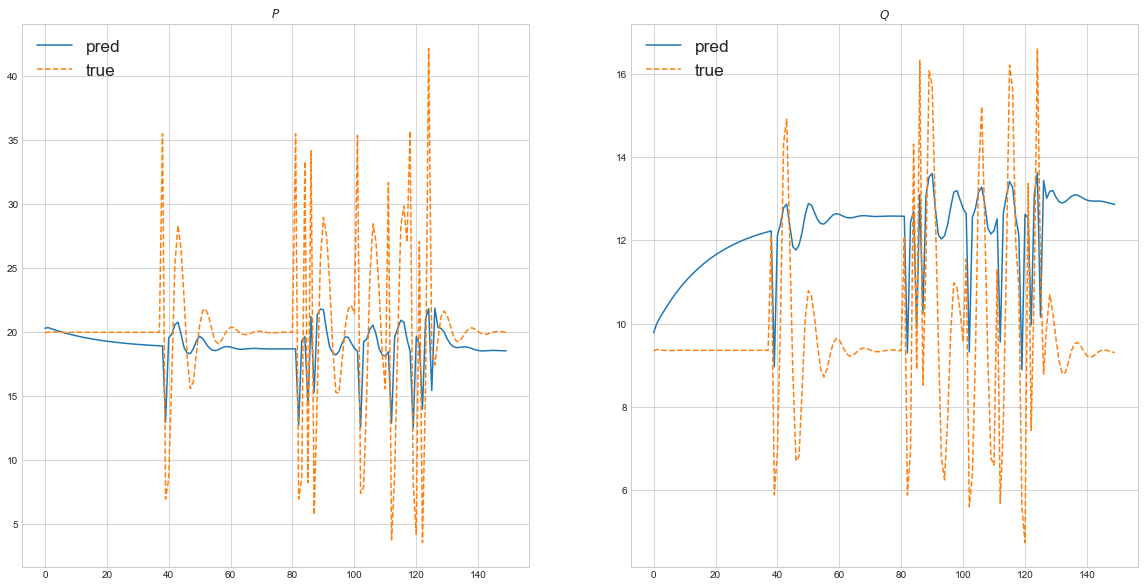

In [21]:
# VAR with exogenous (32)
fig, axes = plt.subplots(1, 2, figsize=(20,10))
for i, (ax, varname, varidx) in enumerate(zip(axes.flatten(), ['$P$', '$Q$'], ['p', 'q'])):
    ax.plot(sc.inverse_transform(np.hstack([data_long[['v', 'phi']].values[train_len:train_len+150],
                                            fc]))[:, 2+i], label='pred')
    plt.plot()
    ax.plot(sc.inverse_transform(np.hstack([data_long[['v', 'phi']].values[train_len:train_len+150],
                                            data_long[['p', 'q']].values[train_len:train_len+150]]))[:, 2+i], 
                                 linestyle='dashed', label='true')
    ax.set_title(varname)
    ax.legend(loc='best', fontsize='xx-large')

In [34]:
errs = []
for offset in range((len(data_long) - train_len) // 151):
    ts = train_len + 151 * offset
    tf = train_len + 151 * (offset + 1)
    true = data_long[['p', 'q']].values[ts:tf]
    pred = var.forecast(y=data_long[['p', 'q']].values[ts-maxlags:ts],
                        steps=tf-ts,
                        exog_future=data_long[['phiD', 'vD']].values[ts:tf])
    t = sc.inverse_transform(np.hstack([data_long[['v', 'phi']].values[ts:tf],
                                        true]))[:, 2:]
    p = sc.inverse_transform(np.hstack([data_long[['v', 'phi']].values[ts:tf],
                                        pred]))[:, 2:]
    err = np.mean(np.sqrt(np.sum((t - p) ** 2, axis=0)) / np.sqrt(np.sum(t ** 2, axis=0)))
    errs.append(err)

In [35]:
print('\n'.join(['RMSE',
                 'mean %.4f' % np.mean(errs).round(4),
                 'median %.4f' % np.median(errs).round(4),
                 'max %.4f' % np.max(errs).round(4),
                 'min %.4f' % np.min(errs).round(4),
                 '95%% percentile %.4f' % np.percentile(errs, 95).round(4)]))

RMSE
mean 0.0111
median 0.0110
max 0.0173
min 0.0058
95% percentile 0.0144


In [ ]:
errno = np.argmax(errs)

In [ ]:
# VAR with exogenous (32)
fc = var.forecast(y=data_long[['p', 'q']].values[train_len + 151 * errno - maxlags:train_len + 151 * errno],
                  steps=151,
                  exog_future=data_long[['phiD', 'vD']].values[train_len + 151 * errno:train_len + 151 * (errno+1)])
fig, axes = plt.subplots(1, 2, figsize=(20,10))
for i, (ax, varname, varidx) in enumerate(zip(axes.flatten(), ['$P$', '$Q$'], ['p', 'q'])):
    ax.plot(fc[:, i], label='pred')
    plt.plot()
    ax.plot(data_long[varidx].values[train_len + 151 * errno:train_len + 151 * (errno+1)], linestyle='dashed', label='true')
    ax.set_title(varname)
    ax.legend(loc='best', fontsize='xx-large')

In [ ]:
var.summary()

In [ ]:
params = var.params

In [ ]:
params = params.flatten('F')[:-4].reshape((-1, 2), order='F')

In [ ]:
const = params[0]
params = params[1:]

In [ ]:
df = pd.DataFrame(params.reshape((-1, 4)), columns=['$\\alpha_{11}$', '$\\alpha_{21}$', '$\\alpha_{12}$', '$\\alpha_{22}$'])

In [ ]:
plt.figure(figsize=(20,10))
for x, name, expl in zip(np.abs(df.values).T, df.columns.values,
                         ['$P = f(\\varphi)$', '$Q = f(\\varphi)$', '$P = f(V)$', '$Q = f(V)$']):
    plt.semilogy(x, label=name + ': ' + expl)
plt.legend(loc='best', fontsize='xx-large')

In [ ]:
np.sum(sc.inverse_transform(np.hstack([data_long[['v', 'phi']][:len(var.resid)], var.resid]))[:, 2:] ** 2, axis=0)

In [60]:
var.save('model_var_scaled_R_0.1_p_32.pkl')

In [12]:
from tqdm import tnrange

## Colormap

In [63]:
errs_mtx = np.zeros((3,3))
for i, r_src in enumerate([10, 1, 0.1]):
    for j, r_dst in enumerate([10, 1, 0.1]):
        data_long = pd.DataFrame(sc.transform(
            np.vstack([pd.read_csv(f'colormap/data_R_{r_dst}/{fname}').drop('t', 1).values \
                       for fname in os.listdir(f'colormap/data_R_{r_dst}') if fname != '.DS_Store'])),
                            columns=['v', 'phi', 'p', 'q'])
        train_len = 200 * 151
        data_long['phiD'] = data_long['phi'].diff()
        data_long['vD'] = data_long['v'].diff()
        data_long = data_long.dropna()
        m = sm.tsa.VAR(endog=data_long[['p', 'q']].values[:train_len],
                       exog=data_long[['phiD', 'vD']].values[:train_len])
        maxlags=32
        var = m.fit(maxlags=maxlags, ic='aic')
        var = var.load(f'model_var_scaled_R_{r_src}_p_32.pkl')
        errs = []
        for offset in range((len(data_long) - train_len) // 151):
            ts = train_len + 151 * offset
            tf = train_len + 151 * (offset + 1)
            true = data_long[['p', 'q']].values[ts:tf]
            pred = var.forecast(y=data_long[['p', 'q']].values[ts-maxlags:ts],
                                steps=tf-ts,
                                exog_future=data_long[['phiD', 'vD']].values[ts:tf])
            t = sc.inverse_transform(np.hstack([data_long[['v', 'phi']].values[ts:tf],
                                                true]))[:, 2:]
            p = sc.inverse_transform(np.hstack([data_long[['v', 'phi']].values[ts:tf],
                                                pred]))[:, 2:]
            err = np.mean(np.sqrt(np.sum((t - p) ** 2, axis=0)) / np.sqrt(np.sum(t ** 2, axis=0)))
            errs.append(err)
        errs_mtx[i, j] = np.mean(errs)

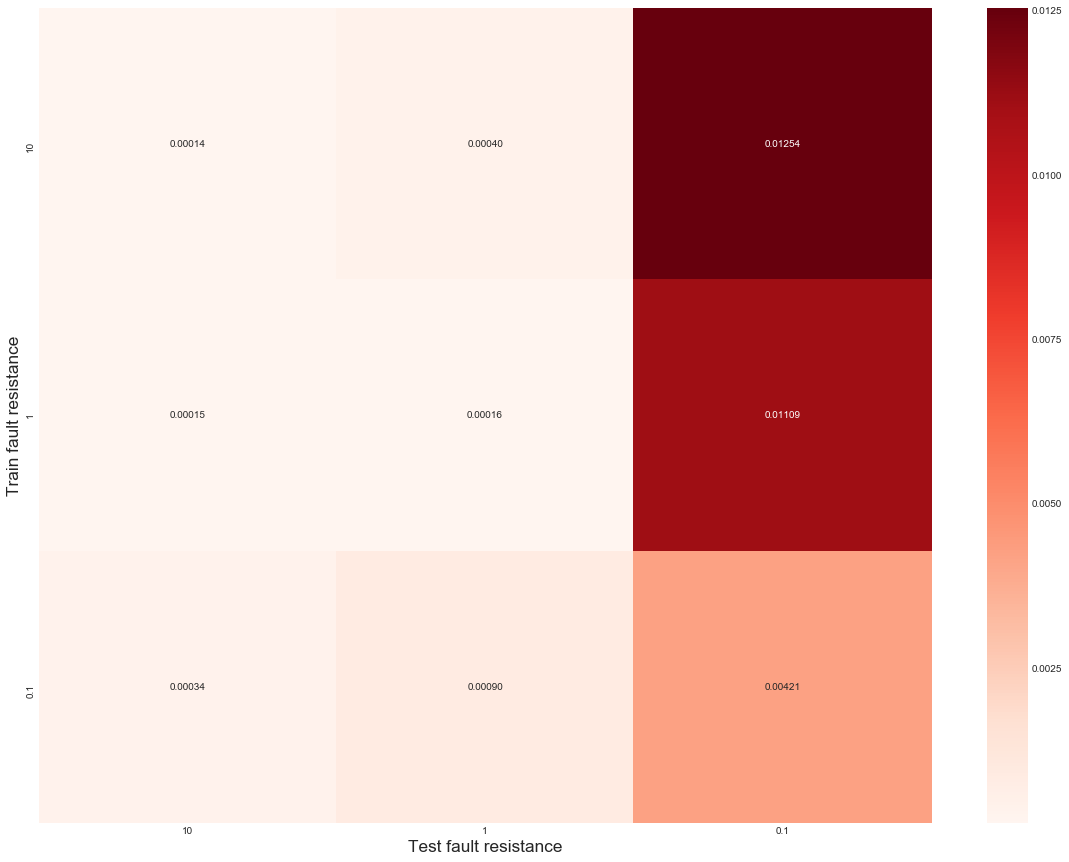

In [103]:
fig = plt.figure(figsize=(20,15))
sns.heatmap(errs_mtx, cmap="Reds", annot=True, fmt='.5f',
            xticklabels=['10', '1', '0.1'], yticklabels=['10', '1', '0.1'])
fig.gca().set_ylabel('Train fault resistance', fontsize='xx-large');
fig.gca().set_xlabel('Test fault resistance', fontsize='xx-large');